## Introduction ##
The main differences between this fork and initial one (https://www.kaggle.com/sadz2201/hitting-the-jackpot-accumulator-betting):

- using combinations of folds!!! 
It's drastically tuned performance and financial resuls
- more teams

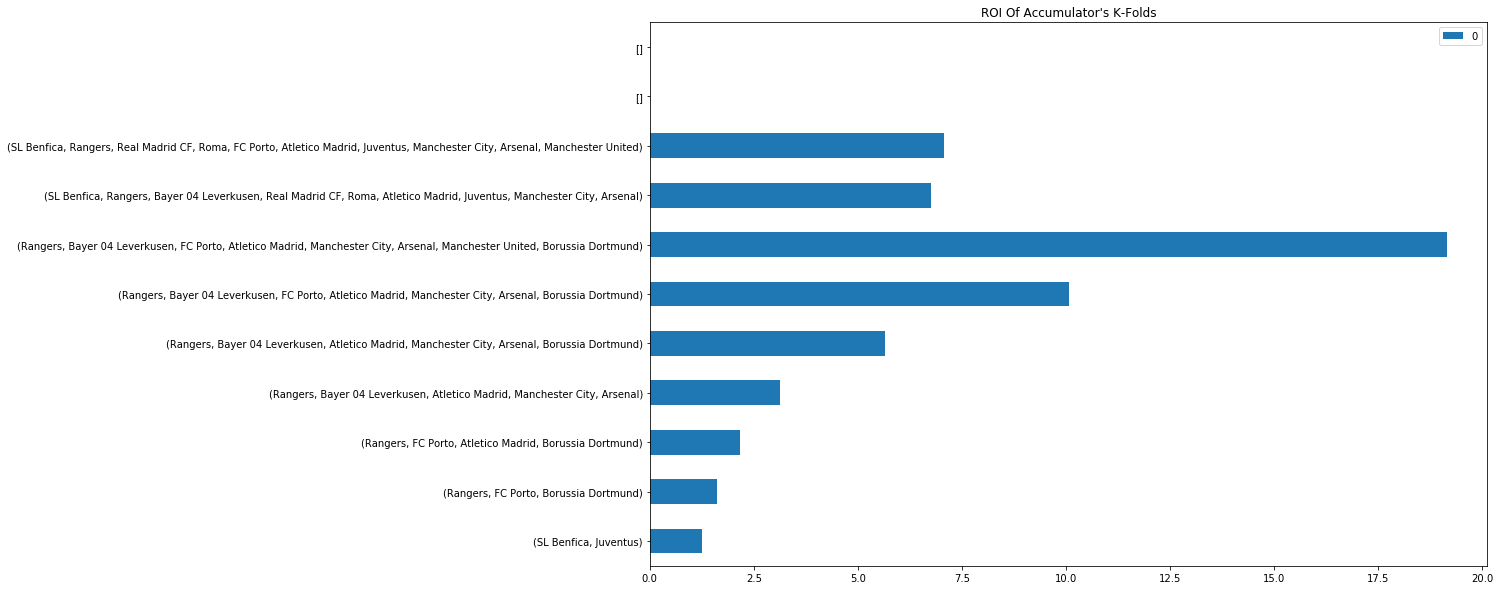

**Import Libraries, load the data**

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta
from itertools import combinations, chain


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('./database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

Merge data, select most recent 5 seasons, retain only relevant columns

In [2]:
#selected_countries = ['Scotland','France','Germany','Italy','Spain','Portugal','England']
#countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

#There's a special character in the long name "Atlético Madrid".
#This can be a pain in the ass, so I'm gonna change it for simplicity.
teams.loc[teams.team_api_id==9906,"team_long_name"] = "Atletico Madrid"

#retain only data from 2011-12 season
#matches=matches[matches.date>='2011-08-01']
#matches = matches[matches.league_id.isin(leagues.id)]
#print(sorted(matches.columns))
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [3]:
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','home_team_goal','away_team_goal','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,1.73,3.40,5.00
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,1.95,3.20,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,2.38,3.30,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,1.44,3.75,7.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,5.00,3.50,1.65


Team API id's don't tell us anything. Lets merge team names

In [4]:
matches=matches.merge(teams,left_on='home_team_api_id',right_on='team_api_id',suffixes=('','_h'))
matches=matches.merge(teams,left_on='away_team_api_id',right_on='team_api_id',suffixes=('','_a'))
matches=matches[['id', 'season', 'date','home_team_goal','away_team_goal','B365H', 'B365D' ,'B365A',
                 'team_long_name','team_long_name_a']]
matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a
0,1,2008/2009,2008-08-17 00:00:00,1,1,1.73,3.40,5.00,KRC Genk,Beerschot AC
1,483,2009/2010,2009-08-30 00:00:00,1,1,1.75,3.50,4.33,KRC Genk,Beerschot AC
2,524,2010/2011,2010-08-01 00:00:00,2,1,1.91,3.30,3.75,KRC Genk,Beerschot AC
3,759,2011/2012,2011-07-30 00:00:00,3,1,1.44,4.33,7.00,KRC Genk,Beerschot AC
4,1014,2012/2013,2012-10-20 00:00:00,3,0,1.50,4.00,6.50,KRC Genk,Beerschot AC


Retain data of only our chosen 12 teams for further analysis. Also since we have multiple teams from the same league (Barca, Real & Atletico from Spain; Bayern & Dortmund from Germany; Benfica & Porto from Portugal; Mancity & Arsenal from EPL), I'll remove the matches where they face off against each other. It's hard to pick a winner in these, so it's best to leave them out of our accumulators

In [5]:
matches.tail()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a
22587,24001,2014/2015,2015-03-20 00:00:00,0,4,3.80,3.40,2.00,Elche CF,Valencia CF
22588,23875,2014/2015,2014-12-20 00:00:00,0,1,3.80,3.30,2.05,SD Eibar,Valencia CF
22589,24240,2015/2016,2015-12-13 00:00:00,1,1,2.45,3.20,3.00,SD Eibar,Valencia CF
22590,23959,2014/2015,2015-02-21 00:00:00,1,2,4.33,3.25,1.95,Córdoba CF,Valencia CF
22591,24422,2015/2016,2016-04-02 00:00:00,2,1,2.38,3.25,3.10,UD Las Palmas,Valencia CF


In [6]:
accumulator_teams=['FC Barcelona','Real Madrid CF', 'Atletico Madrid', 'Sevilla FC',
                   'FC Porto','SL Benfica', 'Sporting SP',
                   'FC Bayern Munich', 'Borussia Dortmund', 'Bayer 04 Leverkusen',
                   'Arsenal', 'Manchester City', 'Chelsea', 'Manchester United', 'Liverpool',
                   'Paris Saint-Germain', 'AS Monaco',  
                   'Juventus', 'Napoli', 'Inter', 'Roma', 'Milan',                  
                   'Celtic', 'Rangers',
                   'Ajax', 'Feyenoord', 'FC Twente', 'PSV']

#matches where any of our 12 teams is playing at home
matches_h=matches[matches.team_long_name.isin(accumulator_teams)]
#matches where any of our 12 teams is playing away
matches_a=matches[matches.team_long_name_a.isin(accumulator_teams)]
#concat & drop duplicates
matches=pd.concat([matches_h,matches_a],axis=0)
matches.drop_duplicates(inplace=True)

matches=matches.sort_values(by='date')
#remove matches where our teams are facing off against each other
matches=matches[~((matches.team_long_name.isin(accumulator_teams)) & 
                  (matches.team_long_name_a.isin(accumulator_teams)))]

matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a
17729,19694,2008/2009,2008-08-09 00:00:00,0,1,6.50,4.0,1.50,Falkirk,Rangers
18266,19698,2008/2009,2008-08-10 00:00:00,1,0,1.17,6.5,17.00,Celtic,St. Mirren
7782,7809,2008/2009,2008-08-15 00:00:00,2,2,1.57,3.8,6.00,FC Bayern Munich,Hamburger SV
3841,1730,2008/2009,2008-08-16 00:00:00,1,0,1.20,6.5,15.00,Arsenal,West Bromwich Albion
2900,1731,2008/2009,2008-08-16 00:00:00,0,1,5.50,3.6,1.67,Sunderland,Liverpool


For our accumulators, we'll have to group the matches based on date. It is highly unlikely that all our teams play a match on the same date, but it is likely that they play within the same gameweek. Thus we need to do some post-processing on dates.

There can be weekend matches (Sat/Sun), or midweek matches (Tue/Wed). In extreme cases, a weekend match can be preponed to Friday or postponed to Monday, or a midweek match postponed to Thursday. 
I'll change the date of all weekend matches to the corresponding Saturday, & all midweek matches to the corresponding Tuesday.

In [7]:
matches.date=pd.to_datetime(matches.date)
#monday matches. subtract 2 to make it saturday
m0=matches[matches.date.dt.weekday==0]
m0.date=m0.date-timedelta(days=2)

#tuesday matches
m1=matches[matches.date.dt.weekday==1]
#wednesday matches. subtract 1 to make it tuesday
m2=matches[matches.date.dt.weekday==2]
m2.date=m2.date-timedelta(days=1)
#thursday matches. subtract 2 to make it tuesday
m3=matches[matches.date.dt.weekday==3]
m3.date=m3.date-timedelta(days=2)

#friday matches. add 1 to make it saturday
m4=matches[matches.date.dt.weekday==4]
m4.date=m4.date+timedelta(days=1)
#saturday matches
m5=matches[matches.date.dt.weekday==5]
#sunday matches. subtract 1 to make it saturday
m6=matches[matches.date.dt.weekday==6]
m6.date=m6.date-timedelta(days=1)

#merge all, sort by date
matches=pd.concat([m0,m1,m2,m3,m4,m5,m6],axis=0)
matches=matches.sort_values(by='date')
del m0,m1,m2,m3,m4,m5,m6

#checking if we have only saturday & tuesday now
matches.date.dt.weekday.value_counts()

5    5751
1     673
Name: date, dtype: int64

Find out which of our chosen teams is playing in each match. Also find the venue & odds for the team. 

In [8]:
matches['our_team']='abc'
matches['our_venue']='H'
matches['our_odds']=matches.B365H

is_home=matches.team_long_name.isin(accumulator_teams)
#our team is playing at home
matches.our_team[is_home==True]=matches.team_long_name[is_home==True]

#our team is playing away.
matches.our_team[is_home==False]=matches.team_long_name_a[is_home==False]
matches.our_venue[is_home==False]='A'
matches.our_odds[is_home==False]=matches.B365A[is_home==False]

Compute the result of each match based on the goals. Also compute our payout for each match assuming we bet 1$ on our chosen team. 

In [9]:
matches['result']='H'
matches.loc[matches.home_team_goal==matches.away_team_goal,"result"]='D'
matches.loc[matches.home_team_goal<matches.away_team_goal,"result"]='A'

matches['payout']=matches.our_odds
#our team either lost or drew. reset payout to 0
matches.loc[~(matches.result==matches.our_venue),"payout"]=0
matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a,our_team,our_venue,our_odds,result,payout
17729,19694,2008/2009,2008-08-09,0,1,6.50,4.0,1.50,Falkirk,Rangers,Rangers,A,1.50,A,1.50
18266,19698,2008/2009,2008-08-09,1,0,1.17,6.5,17.00,Celtic,St. Mirren,Celtic,H,1.17,H,1.17
2900,1731,2008/2009,2008-08-16,0,1,5.50,3.6,1.67,Sunderland,Liverpool,Liverpool,A,1.67,A,1.67
6368,4886,2008/2009,2008-08-16,1,0,2.38,2.9,3.30,Paris Saint-Germain,Girondins de Bordeaux,Paris Saint-Germain,H,2.38,H,2.38
18407,19761,2008/2009,2008-08-16,1,1,5.75,4.0,1.57,Dundee United,Celtic,Celtic,A,1.57,D,0.00


Sanity check: Lets see if we're profitable so far. (Note, this is just individual bets, we haven't gone into accumulators yet).  

In [10]:
print(sum(matches.payout)/matches.shape[0])

0.981897571606


In [11]:
team_n=matches.our_team.value_counts()
print ("win percentage by team:")
print(matches[matches.payout!=0].our_team.value_counts()/team_n)
print("_"*50)
print ("net payout by team:")
indiv_payout=matches.groupby('our_team')['payout'].sum()
indiv_payout=indiv_payout/team_n
print(indiv_payout)

win percentage by team:
AS Monaco              0.421296
Ajax                   0.687500
Arsenal                0.637500
Atletico Madrid        0.605469
Bayer 04 Leverkusen    0.545833
Borussia Dortmund      0.600000
Celtic                 0.736111
Chelsea                0.620833
FC Barcelona           0.781250
FC Bayern Munich       0.741667
FC Porto               0.754310
FC Twente              0.598214
Feyenoord              0.556054
Inter                  0.560669
Juventus               0.651261
Liverpool              0.537500
Manchester City        0.637500
Manchester United      0.675000
Milan                  0.571429
Napoli                 0.550420
PSV                    0.709821
Paris Saint-Germain    0.595890
Rangers                0.742647
Real Madrid CF         0.796875
Roma                   0.589958
SL Benfica             0.782609
Sevilla FC             0.501961
Name: our_team, dtype: float64
__________________________________________________
net payout by team:
AS Monaco 

Juventus & Benfica seem to be our star performers, with 14 & 10.68% profit themselves. I'm quite surprised that Atletico, PSG & Manchester City are profitable or even despite a low wins percentage, while Barcelona have losses. Also, the net payout for Real Madrid & Arsenal is nearly identical, despite Real winning 79.4% of their matches and Arsenal only winning 58.33%. Although a few teams have losses, I do believe they can help improve the overall profits of our accumulators because of their good wins percentage. 

**Accumulator**
If you just increase nlargest=16 you will get more cooler results - ![enter image description here][1]


  [1]: https://content.screencast.com/users/SASH2012/folders/Jing/media/14dc7b87-980c-467d-b594-aca9f4275362/2017-05-21_0051.png

In [12]:
#our teams list in sorted order of individual profits
accumulator_teams = indiv_payout.nlargest(12).index.values
print(accumulator_teams)

[u'SL Benfica' u'Rangers' u'Bayer 04 Leverkusen' u'Real Madrid CF' u'Roma'
 u'FC Porto' 'Atletico Madrid' u'Juventus' u'Manchester City' u'Arsenal'
 u'Manchester United' u'Borussia Dortmund']


In [13]:
#list of bet365 bonus payouts
#bonus[k]= bet365 bonus for k-fold accumulator
#bonus=[1,1,1,1.05,1.1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
# I just wanted to see performance even without bonuses
bonus = (len(accumulator_teams)+1) * [1.0]

#blank dict
accum_payouts = {}
best_subset = {}
summary = pd.DataFrame()
for k in range(2, len(accumulator_teams)+1):
    accum_payouts[k] = 0
    best_subset[k] = []
    for accum_subset in combinations(accumulator_teams, k):
        #choose only matches involving these teams
        matches_kfold = matches[matches.our_team.isin(accum_subset)]
        #count of matches per date.
        date_counts = matches_kfold.date.value_counts().reset_index()
        date_counts.columns=['date','counts']

        #select only the dates where all k teams are in action
        dates_kfold = date_counts[date_counts.counts==k].date
        #retain only the matches happening on these dates
        matches_kfold = matches_kfold[matches_kfold.date.isin(dates_kfold)]
        #k-fold accumulator payout (product of payouts of all k teams on that date)
        payout_kfold = matches_kfold.groupby('date')['payout'].prod()
        if len(payout_kfold) == 0:
            continue
        summary = pd.concat([summary, payout_kfold.rename(accum_subset)], axis=1)
        #multiply bonus
        #bonus_payout_kfold = payout_kfold * bonus[k]
        #print(str(k) + " fold:")
        #print(accum_subset)
        #print("#bets: " + str(len(payout_kfold)))
        #print("#correct predictions: " + str(len(payout_kfold[payout_kfold!=0])))
        #print("Net outcome (without bonus): " + str(sum(payout_kfold)/len(payout_kfold)))
        #print("Net outcome (after bonus): " + str(sum(bonus_payout_kfold)/len(payout_kfold)))
        #print("_"*50)
        if sum(payout_kfold)/len(payout_kfold) > accum_payouts[k]:
            accum_payouts[k] = sum(payout_kfold)/len(payout_kfold)
            best_subset[k] = accum_subset
    print('{}-folds best payout={} -> {}'.format(k, accum_payouts[k], best_subset[k]))
    
#print the best choice of k, the corresponding teams & net payout.
best_k=max(accum_payouts,key=accum_payouts.get)
print("best k=" +str(best_k) )
#print(accumulator_teams[:best_k])
print(best_subset[best_k])
print("best payout= " +str(accum_payouts[best_k]))

2-folds best payout=1.24694716981 -> (u'SL Benfica', u'Juventus')
3-folds best payout=1.60458477612 -> (u'Rangers', u'FC Porto', u'Borussia Dortmund')
4-folds best payout=2.17290459577 -> (u'Rangers', u'FC Porto', 'Atletico Madrid', u'Borussia Dortmund')
5-folds best payout=3.12076677696 -> (u'Rangers', u'Bayer 04 Leverkusen', 'Atletico Madrid', u'Manchester City', u'Arsenal')
6-folds best payout=5.65461529548 -> (u'Rangers', u'Bayer 04 Leverkusen', 'Atletico Madrid', u'Manchester City', u'Arsenal', u'Borussia Dortmund')
7-folds best payout=10.0799181 -> (u'Rangers', u'Bayer 04 Leverkusen', u'FC Porto', 'Atletico Madrid', u'Manchester City', u'Arsenal', u'Borussia Dortmund')
8-folds best payout=19.1571496101 -> (u'Rangers', u'Bayer 04 Leverkusen', u'FC Porto', 'Atletico Madrid', u'Manchester City', u'Arsenal', u'Manchester United', u'Borussia Dortmund')
9-folds best payout=6.76138036681 -> (u'SL Benfica', u'Rangers', u'Bayer 04 Leverkusen', u'Real Madrid CF', u'Roma', 'Atletico Madrid'

**"Super Success!"**

We've just found that accumulators can be a winning strategy. 

Next parts will be continued ...

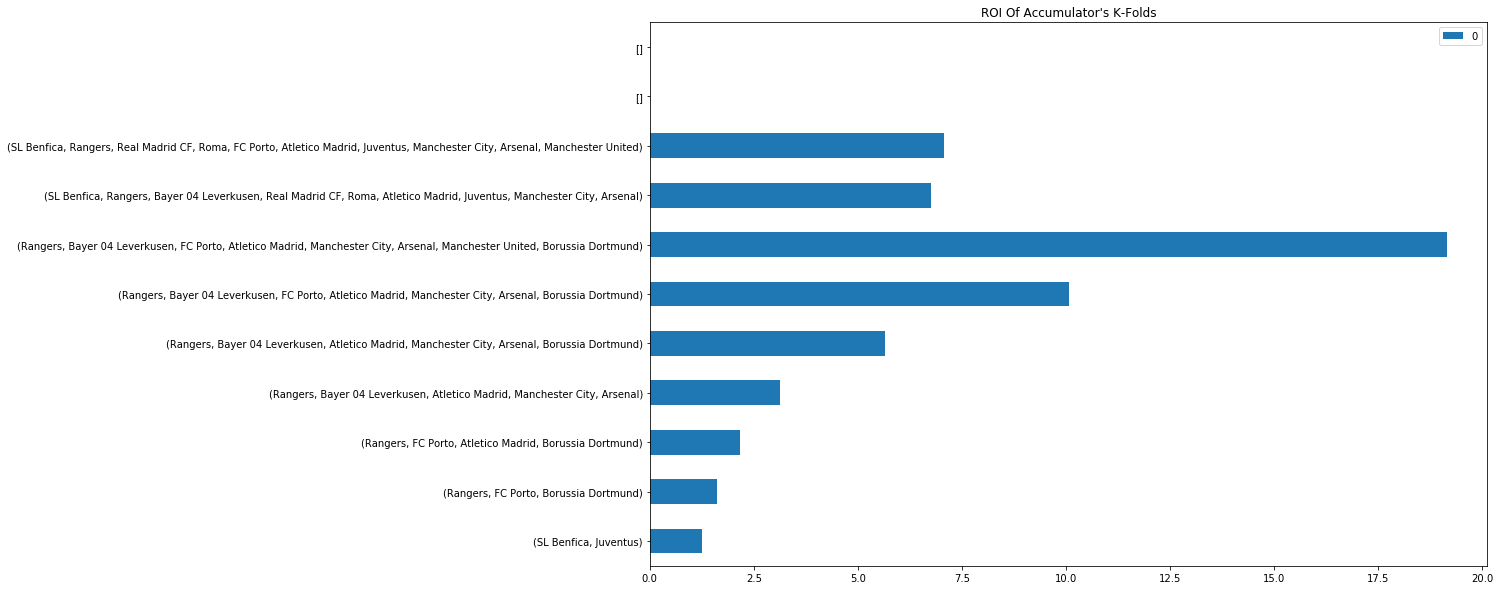

In [49]:
pd.DataFrame(data=accum_payouts.values(), index=best_subset.values()).plot(
    kind='barh', figsize=(15,10),
    title="ROI Of Accumulator's K-Folds"
)

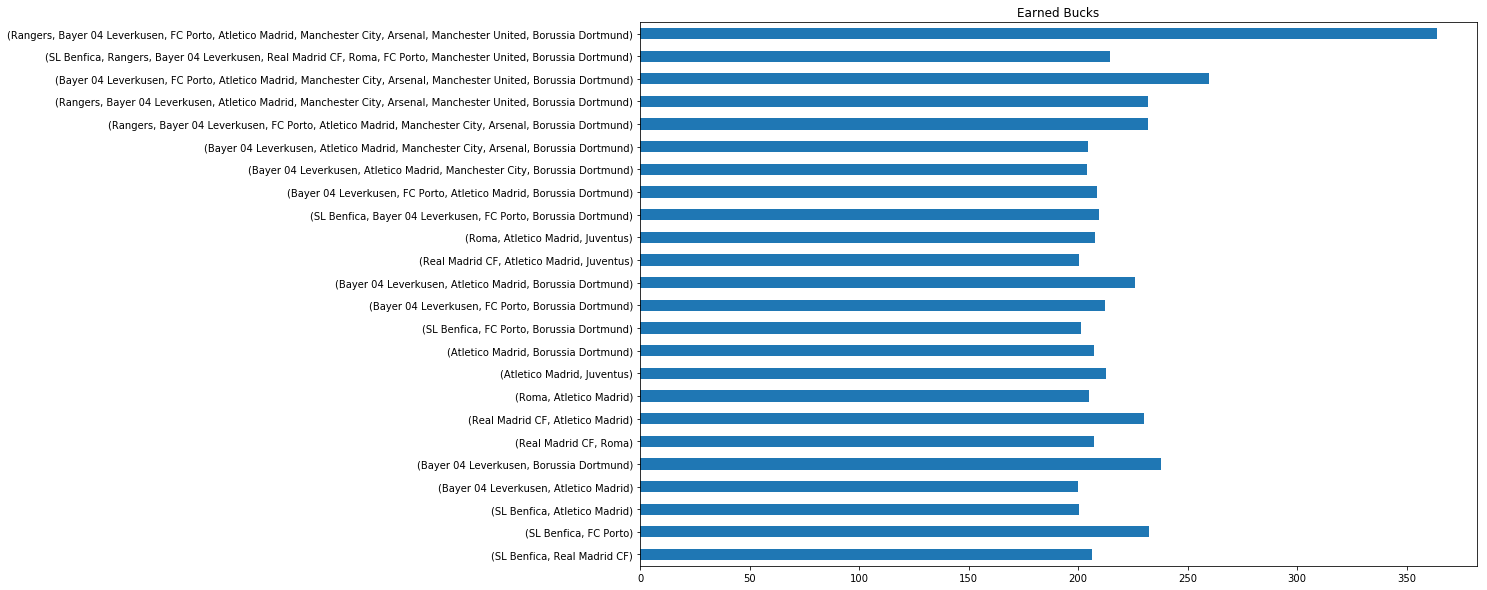

In [46]:
summary[np.array(summary.columns)[summary.sum() > 200]].sum().plot(
    kind='barh', figsize=(15,10),
    title='Earned Bucks'
)
